In [ ]:
! pip -q uninstall -y torch torchtext torchaudio torchvision

In [ ]:
! pip -q install --no-cache-dir torch torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/cu121

In [ ]:
import math
import json
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Iterable, Optional

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())

torch: 2.5.1+cu121
cuda available: True


In [ ]:
@dataclass
class Config:
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # text encoder
    max_len: int = 32
    text_emb_dim: int = 128
    text_hidden_dim: int = 256

    # item encoder
    cat_emb_dim: int = 32
    item_hidden_dim: int = 256

    # shared embedding dim
    embed_dim: int = 256

    # contrastive
    temperature: float = 0.12

    # training
    batch_size: int = 256     # 배치 내 item_id 중복 금지 조건에서의 "유니크 아이템 수"
    num_epochs: int = 3
    lr: float = 3e-4
    weight_decay: float = 1e-4
    grad_clip: float = 1.0
    log_every: int = 100

cfg = Config()

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

cfg.text_use_attn = True
cfg.text_attn_nhead = 4
cfg.text_attn_ff = 256

set_seed(cfg.seed)
print(cfg)

Config(seed=42, device='cuda', max_len=32, text_emb_dim=128, text_hidden_dim=256, cat_emb_dim=32, item_hidden_dim=256, embed_dim=256, temperature=0.12, batch_size=256, num_epochs=3, lr=0.0003, weight_decay=0.0001, grad_clip=1.0, log_every=100)


In [ ]:
# -----------------------------
# Weather label -> temperature range (°C)
# -----------------------------
# "적당히 한국인의 정서" 기준으로 만든 규칙표 (과학적 절대값이 아니라 운영 규칙)
WEATHER_LABEL_TO_TEMP_RANGE: Dict[str, Tuple[int, int]] = {
    "한파":   (-99, -15),
    "한겨울": (-14,   3),
    "쌀쌀":   ( 4,  11),
    "선선":   (12,  18),
    "따뜻":   (19,  27),
    "더움":   (28,  35),
    "폭염":   (36,  99),
}

# 사용자가 날씨 라벨 대신 직접 범위를 바꾸고 싶으면 여기만 수정하면 전체 파이프라인이 유지됩니다.

def parse_temperature_to_int(temp_text: str) -> int:
    """
    날씨 API에서 들어오는 '기온 텍스트'를 정수(°C)로 변환.
    예시 처리:
      - "8", "8도", "8°C", "8 C"
      - "영하 3도", "-3도", "-3°C"
      - "영상 2도"
    규칙:
      - 가장 먼저 발견되는 숫자를 사용
      - 영하/마이너스는 음수 처리
      - 소수면 반올림(0.5 이상 올림)
    """
    if temp_text is None:
        raise ValueError("temp_text is None")

    s = str(temp_text).strip().lower()
    if len(s) == 0:
        raise ValueError("temp_text is empty")

    # 음수 표기 감지
    negative = False
    if "영하" in s or s.startswith("-"):
        negative = True

    # 숫자(정수/소수) 추출
    import re
    m = re.search(r"(-?\d+(\.\d+)?)", s)
    if not m:
        raise ValueError(f"cannot parse temperature from: {temp_text}")

    val = float(m.group(1))
    # "영하 3도"에서 숫자가 3으로 잡히는 경우 보정
    if negative and val > 0:
        val = -val

    # 반올림해서 int로
    return int(round(val))

print("Weather mapping table:", WEATHER_LABEL_TO_TEMP_RANGE)
print("Temp parser test:", parse_temperature_to_int("영하 3도"), parse_temperature_to_int("8.4°C"))

Weather mapping table: {'한파': (-99, -15), '한겨울': (-14, 3), '쌀쌀': (4, 11), '선선': (12, 18), '따뜻': (19, 27), '더움': (28, 35), '폭염': (36, 99)}
Temp parser test: -3 8


In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/학회 신기플/kfashion_train_label_filled_utf8sig_plus678.csv"
VAL_PATH   = "/content/drive/MyDrive/Colab Notebooks/학회 신기플/kfashion_val_filled_utf8sig_plus345678.csv"
TEST_PATH  = "/content/drive/MyDrive/Colab Notebooks/학회 신기플/kfashion_test_filled_utf8sig_plus345678.csv"

df_train = pd.read_csv(TRAIN_PATH)
df_val   = pd.read_csv(VAL_PATH)
df_test  = pd.read_csv(TEST_PATH)

print("train:", df_train.shape, "val:", df_val.shape, "test:", df_test.shape)
print("columns:", df_train.columns.tolist())
print("weather labels(train):", sorted(df_train["날씨"].dropna().unique().tolist()))

train: (127002, 21) val: (85407, 107) test: (85408, 107)
columns: ['image_name', 'image_id', 'part', '카테고리', '색상', '서브색상', '소매기장', '기장', '핏', '옷깃', '스타일', '서브스타일', '날씨', '구체적인 상황 1', '구체적인 상황 2', '구체적인 상황 3', '핵심키워드 4', '핵심키워드 5', '구체적인 상황 6', '구체적인 상황 7', '구체적인 상황 8']
weather labels(train): ['더움', '따뜻', '선선', '쌀쌀', '폭염', '한겨울', '한파']


In [ ]:
# -----------------------------
# 1) 입력 피처 정의 (스타일 제외)
# -----------------------------
ID_COL = "image_id"

FEATURE_COLS = [
    "part", "카테고리", "색상", "서브색상", "소매기장", "기장", "핏", "옷깃",
    # "스타일",  # <-- 제외 (데이터 누수 방지)
    "서브스타일",
    "날씨",     # 라벨 자체도 피처로 쓰는 건 가능(사용자 요구에서 제외 요청 없음)
]

# -----------------------------
# 2) 정답 텍스트 컬럼: 상황 1~8(데이터상 실제 존재는 1,2,3,6,7,8)
# -----------------------------
SITU_COLS = ["구체적인 상황 1", "구체적인 상황 2", "구체적인 상황 3",
             "구체적인 상황 6", "구체적인 상황 7", "구체적인 상황 8"]

# (선택 옵션) 핵심키워드까지 포함하고 싶으면 True로
USE_CORE_KEYWORDS = True
CORE_KEYWORD_COLS = ["핵심키워드 4", "핵심키워드 5"]

TEXT_COLS = SITU_COLS + (CORE_KEYWORD_COLS if USE_CORE_KEYWORDS else [])

# -----------------------------
# 3) item_table + pairs 생성 (train 기준)
#    item_table에 temp_range(정수)도 추가
# -----------------------------
def build_item_table_and_pairs(df: pd.DataFrame) -> Tuple[Dict[str, dict], List[dict]]:
    item_table: Dict[str, dict] = {}
    pairs: List[dict] = []

    for _, row in df.iterrows():
        iid = str(row[ID_COL])

        # item_table 구성 (아이템당 1회만)
        if iid not in item_table:
            it = {}
            for c in FEATURE_COLS:
                v = row.get(c, None)
                it[c] = None if (pd.isna(v)) else str(v)

            # temp_range 생성: 날씨 라벨 -> 구간
            wlabel = it.get("날씨", None)
            if wlabel not in WEATHER_LABEL_TO_TEMP_RANGE:
                # 데이터에 없는 라벨이면 일단 매우 넓게 (운영 중엔 라벨 정합성을 맞추는 게 정상)
                it["temp_range"] = (-50, 50)
            else:
                it["temp_range"] = WEATHER_LABEL_TO_TEMP_RANGE[wlabel]

            item_table[iid] = it

        # pairs 구성 (상황 텍스트 1~8)
        for col in TEXT_COLS:
            txt = row.get(col, "")
            if isinstance(txt, str) and txt.strip():
                t = txt.strip()
                # 길이 제한(요구사항이 원래 생성 규칙에 있었지만, 데이터에도 혹시 이상치 있으면 방어)
                if 3 <= len(t) <= 32:
                    pairs.append({"item_id": iid, "text": t})
                else:
                    # 길이 범위를 벗어나면 제외 (학습 분포 안정)
                    continue

    return item_table, pairs

item_table, pairs = build_item_table_and_pairs(df_train)

print("items:", len(item_table))
print("pairs:", len(pairs))
print("sample item:", list(item_table.items())[:1])
print("sample pairs:", pairs[:3])

items: 85268
pairs: 1016016
sample item: [('37573', {'part': '상의', '카테고리': '니트웨어', '색상': '베이지', '서브색상': '없음', '소매기장': '긴팔', '기장': '없음', '핏': '노멀', '옷깃': '없음', '서브스타일': '컨트리', '날씨': '쌀쌀', 'temp_range': (4, 11)})]
sample pairs: [{'item_id': '37573', 'text': '베이지 긴팔 로맨틱'}, {'item_id': '37573', 'text': '쌀쌀 날 노멀 핏 없음 연출'}, {'item_id': '37573', 'text': '컨트리 무드 베이지 포인트'}]


In [ ]:
from collections import Counter
from torchtext.data.utils import get_tokenizer

class SimpleVocab:
    """
    torchtext.vocab.Vocab과 비슷한 인터페이스만 흉내낸 최소 구현
    (get_stoi / get_itos 제공)
    """
    def __init__(self, itos: list[str], stoi: dict[str, int]):
        self._itos = itos
        self._stoi = stoi

    def get_itos(self):
        return self._itos

    def get_stoi(self):
        return self._stoi

    def __len__(self):
        return len(self._itos)

class TextVocab:
    def __init__(self, vocab, pad_idx: int, unk_idx: int, tokenizer):
        self.vocab = vocab
        self.pad_idx = pad_idx
        self.unk_idx = unk_idx
        self.tokenizer = tokenizer

    def encode(self, text: str, max_len: int):
        tokens = self.tokenizer(text)
        stoi = self.vocab.get_stoi()
        ids = [stoi.get(t, self.unk_idx) for t in tokens][:max_len]
        attn = [1] * len(ids)
        if len(ids) < max_len:
            pad_len = max_len - len(ids)
            ids += [self.pad_idx] * pad_len
            attn += [0] * pad_len
        return torch.tensor(ids, dtype=torch.long), torch.tensor(attn, dtype=torch.long)

def build_text_vocab(texts, min_freq: int = 1) -> TextVocab:
    tokenizer = get_tokenizer("basic_english")

    counter = Counter()
    for t in texts:
        counter.update(tokenizer(t))

    # specials 고정: pad=0, unk=1
    itos = ["<pad>", "<unk>"]
    # min_freq 이상인 토큰만 추가 (빈도 내림차순 -> 토큰명 정렬로 tie break)
    tokens = [tok for tok, c in counter.items() if c >= min_freq]
    tokens.sort(key=lambda x: (-counter[x], x))

    itos.extend(tokens)
    stoi = {tok: i for i, tok in enumerate(itos)}

    vocab = SimpleVocab(itos=itos, stoi=stoi)
    return TextVocab(vocab=vocab, pad_idx=stoi["<pad>"], unk_idx=stoi["<unk>"], tokenizer=tokenizer)

# 사용
text_vocab = build_text_vocab([r["text"] for r in pairs], min_freq=1)
print("vocab size:", len(text_vocab.vocab))

vocab size: 300


In [ ]:
def build_maps_from_item_table(item_table: Dict[str, dict], feature_cols: List[str]) -> Dict[str, Dict[str, int]]:
    maps = {}
    for col in feature_cols:
        vals = set()
        for it in item_table.values():
            v = it.get(col, None)
            if v is None:
                continue
            vals.add(str(v))
        vocab = {"<unk>": 0}
        for v in sorted(vals):
            vocab[v] = len(vocab)
        maps[col] = vocab
    return maps

maps = build_maps_from_item_table(item_table, FEATURE_COLS)
print({c: len(maps[c]) for c in maps})

{'part': 5, '카테고리': 22, '색상': 23, '서브색상': 23, '소매기장': 7, '기장': 12, '핏': 9, '옷깃': 11, '서브스타일': 25, '날씨': 8}


In [ ]:
class PairDataset(Dataset):
    def __init__(self, pairs, item_table, text_vocab, cfg, maps, feature_cols):
        self.pairs = pairs
        self.item_table = item_table
        self.text_vocab = text_vocab
        self.cfg = cfg
        self.maps = maps
        self.feature_cols = feature_cols

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        row = self.pairs[idx]
        item_id = row["item_id"]
        text = row["text"]

        input_ids, attn = self.text_vocab.encode(text, self.cfg.max_len)
        item = self.item_table[item_id]

        feats = {}
        for col in self.feature_cols:
            m = self.maps[col]
            v = item.get(col, None)
            v = "<unk>" if (v is None) else str(v)
            feats[col] = torch.tensor(m.get(v, 0), dtype=torch.long)

        return {
            "item_id": item_id,
            "input_ids": input_ids,
            "attention_mask": attn,
            "feats": feats
        }

def collate_fn(batch):
    input_ids = torch.stack([b["input_ids"] for b in batch], dim=0)
    attn = torch.stack([b["attention_mask"] for b in batch], dim=0)
    item_ids = [b["item_id"] for b in batch]

    feat_keys = batch[0]["feats"].keys()
    feats = {k: torch.stack([b["feats"][k] for b in batch], dim=0) for k in feat_keys}

    return {"item_ids": item_ids, "input_ids": input_ids, "attention_mask": attn, "feats": feats}

print("Dataset ready.")

Dataset ready.


In [ ]:
import math, random
from torch.utils.data import Sampler

class StyleFirstSubstyleSecondUniqueSampler(Sampler):
    """
    배치 내 item_id 중복을 '절대' 허용하지 않으며,
    스타일을 1순위로 다양화하고, 스타일 내부에서 서브스타일을 2순위로 다양화한다.

    - style_key 우선
    - substyle_key는 같은 style 내에서 라운드로빈으로 분산
    - 배치가 부족하면 제약을 완화해서 채우되, 중복은 절대 없음
    """

    def __init__(
        self,
        pairs,
        item_table,
        batch_size,
        style_key="스타일",
        substyle_key="서브스타일",
        drop_last=True,
        shuffle=True,
        max_per_style_in_batch=None,        # 기본: batch_size//16
        max_per_none_style_in_batch=8,      # style이 없거나 '없음' 계열인 경우 cap
        none_tokens=("없음", "None", "nan", "NaN", ""),
    ):
        self.pairs = pairs
        self.item_table = item_table
        self.batch_size = int(batch_size)
        self.drop_last = drop_last
        self.shuffle = shuffle

        self.style_key = style_key
        self.substyle_key = substyle_key

        self.none_tokens = set(map(str, none_tokens))

        if max_per_style_in_batch is None:
            self.max_per_style_in_batch = max(4, self.batch_size // 16)  # 256이면 16
        else:
            self.max_per_style_in_batch = int(max_per_style_in_batch)

        self.max_per_none_style_in_batch = int(max_per_none_style_in_batch)

        # item_id -> pair indices
        self.item_to_indices = {}
        for i, r in enumerate(pairs):
            self.item_to_indices.setdefault(r["item_id"], []).append(i)
        self.items = list(self.item_to_indices.keys())

        def norm_label(x):
            if x is None:
                return "<none>"
            s = str(x).strip()
            if s in self.none_tokens:
                return "<none>"
            return s

        # style/substyle per item
        self.item_style = {}
        self.item_substyle = {}
        for iid in self.items:
            it = item_table.get(iid, {})
            self.item_style[iid] = norm_label(it.get(style_key, None))
            self.item_substyle[iid] = norm_label(it.get(substyle_key, None))

        # style -> substyle -> [items]
        self.style_sub_items = {}
        for iid in self.items:
            st = self.item_style[iid]
            sb = self.item_substyle[iid]
            self.style_sub_items.setdefault(st, {}).setdefault(sb, []).append(iid)

        self.styles = list(self.style_sub_items.keys())

    def __len__(self):
        n = len(self.items)
        return (n // self.batch_size) if self.drop_last else math.ceil(n / self.batch_size)

    def __iter__(self):
        # 에폭마다 "아이템은 1번만 쓰자"에 가까운 동작을 위해,
        # style/substyle 리스트를 셔플하고 포인터로 소진하는 방식 사용
        styles = self.styles[:]
        if self.shuffle:
            random.shuffle(styles)

        # style별 substyle 목록 셔플 + 각 substyle의 item 목록 셔플
        style_to_subs = {}
        for st in styles:
            submap = self.style_sub_items[st]
            subs = list(submap.keys())
            if self.shuffle:
                random.shuffle(subs)
                for sb in subs:
                    random.shuffle(submap[sb])
            style_to_subs[st] = subs

        # 포인터들
        ptr_item = {(st, sb): 0 for st in styles for sb in style_to_subs[st]}
        ptr_sub = {st: 0 for st in styles}

        # 남은 아이템이 있는지
        def has_remaining(st):
            submap = self.style_sub_items[st]
            for sb in style_to_subs[st]:
                if ptr_item[(st, sb)] < len(submap[sb]):
                    return True
            return False

        # style에서 하나 꺼내기: substyle 라운드로빈
        def pop_one(st):
            subs = style_to_subs[st]
            if not subs:
                return None
            submap = self.style_sub_items[st]
            for _ in range(len(subs)):
                j = ptr_sub[st] % len(subs)
                sb = subs[j]
                ptr_sub[st] = (ptr_sub[st] + 1) % len(subs)
                k = ptr_item[(st, sb)]
                if k < len(submap[sb]):
                    iid = submap[sb][k]
                    ptr_item[(st, sb)] += 1
                    return iid
            return None

        # 배치 구성
        batch = []
        used_items = set()
        style_count = {}

        # PASS1: 스타일 cap을 지키며 채우기
        while True:
            progressed = False
            if self.shuffle:
                random.shuffle(styles)

            for st in styles:
                if len(batch) >= self.batch_size:
                    break
                if not has_remaining(st):
                    continue

                cap = self.max_per_none_style_in_batch if st == "<none>" else self.max_per_style_in_batch
                if style_count.get(st, 0) >= cap:
                    continue

                iid = pop_one(st)
                if iid is None:
                    continue
                if iid in used_items:
                    continue  # ✅ 배치 내 중복 절대 금지

                idx = random.choice(self.item_to_indices[iid])
                batch.append(idx)
                used_items.add(iid)
                style_count[st] = style_count.get(st, 0) + 1
                progressed = True

            if len(batch) == self.batch_size:
                yield batch
                batch, used_items, style_count = [], set(), {}
                continue

            # PASS2: 제약 완화(스타일 cap 무시)해서 "남아 있는 것" 중에서 채우기
            # 단, 여전히 배치 내 item_id 중복은 금지
            if len(batch) < self.batch_size:
                # 남은 후보를 한 번 훑어서 채움 (비용 줄이려면 스타일 순회)
                for st in styles:
                    if len(batch) >= self.batch_size:
                        break
                    while has_remaining(st) and len(batch) < self.batch_size:
                        iid = pop_one(st)
                        if iid is None:
                            break
                        if iid in used_items:
                            continue
                        idx = random.choice(self.item_to_indices[iid])
                        batch.append(idx)
                        used_items.add(iid)
                        progressed = True

            if len(batch) == self.batch_size:
                yield batch
                batch, used_items, style_count = [], set(), {}
                continue

            if not progressed:
                break

        if len(batch) > 0 and not self.drop_last:
            yield batch

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, out_dim, pad_idx,
                 use_attn=False, nhead=4, ff_dim=256):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.use_attn = use_attn
        if use_attn:
            layer = nn.TransformerEncoderLayer(
                d_model=emb_dim, nhead=nhead, dim_feedforward=ff_dim, batch_first=True
            )
            self.attn = nn.TransformerEncoder(layer, num_layers=1)
        else:
            self.attn = None

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, input_ids, attention_mask):
        x = self.emb(input_ids)
        if self.use_attn:
            key_padding_mask = (attention_mask == 0)
            x = self.attn(x, src_key_padding_mask=key_padding_mask)
        mask = attention_mask.unsqueeze(-1).float()
        x = x * mask
        denom = mask.sum(dim=1).clamp_min(1.0)
        pooled = x.sum(dim=1) / denom
        z = self.mlp(pooled)
        return F.normalize(z, dim=-1)


class ItemEncoder(nn.Module):
    """
    FEATURE_COLS의 각 컬럼을 embedding -> concat -> MLP
    """
    def __init__(self, maps, feature_cols, emb_dim, hidden_dim, out_dim):
        super().__init__()
        self.feature_cols = feature_cols
        self.embs = nn.ModuleDict({col: nn.Embedding(len(maps[col]), emb_dim) for col in feature_cols})

        in_dim = emb_dim * len(feature_cols)
        self.proj = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, feats):
        vecs = []
        for col in self.feature_cols:
            vecs.append(self.embs[col](feats[col]))  # (B,emb)
        x = torch.cat(vecs, dim=1)
        z = self.proj(x)
        return F.normalize(z, dim=-1)


def contrastive_loss(z_text: torch.Tensor, z_item: torch.Tensor, temperature: float) -> torch.Tensor:
    logits = (z_text @ z_item.T) / temperature
    targets = torch.arange(logits.size(0), device=logits.device)
    loss_t2i = F.cross_entropy(logits, targets)
    loss_i2t = F.cross_entropy(logits.T, targets)
    return 0.5 * (loss_t2i + loss_i2t)

print("Models & loss ready.")

Models & loss ready.


In [ ]:
def train_one_epoch(text_enc: nn.Module, item_enc: nn.Module, loader: DataLoader, opt, cfg: Config):
    text_enc.train(); item_enc.train()
    total = 0.0

    for step, batch in enumerate(loader):
        input_ids = batch["input_ids"].to(cfg.device)
        attn = batch["attention_mask"].to(cfg.device)
        feats = {k: v.to(cfg.device) for k, v in batch["feats"].items()}

        zt = text_enc(input_ids, attn)
        zi = item_enc(feats)
        loss = contrastive_loss(zt, zi, cfg.temperature)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        if cfg.grad_clip is not None:
            nn.utils.clip_grad_norm_(list(text_enc.parameters()) + list(item_enc.parameters()), cfg.grad_clip)
        opt.step()

        total += float(loss.item())
        if (step + 1) % cfg.log_every == 0:
            print(f"[train] step {step+1}/{len(loader)} loss={total/(step+1):.4f}")

    return total / max(1, len(loader))

print("Train loop ready.")

@torch.no_grad()
def eval_inbatch_metrics(text_enc, item_enc, loader, cfg, max_batches=50):
    text_enc.eval(); item_enc.eval()
    acc1_list = []
    pos_list = []
    negmax_list = []
    margin_list = []

    for b, batch in enumerate(loader):
        if b >= max_batches:
            break

        input_ids = batch["input_ids"].to(cfg.device)
        attn = batch["attention_mask"].to(cfg.device)
        feats = {k: v.to(cfg.device) for k, v in batch["feats"].items()}

        zt = text_enc(input_ids, attn)
        zi = item_enc(feats)

        sims = (zt @ zi.T)  # (B,B)
        B = sims.size(0)
        targets = torch.arange(B, device=sims.device)

        # top1 acc
        pred = sims.argmax(dim=1)
        acc1 = (pred == targets).float().mean().item()
        acc1_list.append(acc1)

        # pos, negmax, margin
        pos = sims[targets, targets]
        sims_masked = sims.clone()
        sims_masked[targets, targets] = -1e9
        negmax = sims_masked.max(dim=1).values

        pos_list.append(pos.mean().item())
        negmax_list.append(negmax.mean().item())
        margin_list.append((pos - negmax).mean().item())

    return {
        "acc1": float(np.mean(acc1_list)),
        "pos_mean": float(np.mean(pos_list)),
        "negmax_mean": float(np.mean(negmax_list)),
        "margin_mean": float(np.mean(margin_list)),
    }

Train loop ready.


In [ ]:
# --- val item_table / pairs 생성 ---
val_item_table, val_pairs = build_item_table_and_pairs(df_val)

# (중요) train vocab을 그대로 쓰는 게 일반적 (val로 vocab 확장하면 누수/불안정)
# text_vocab 그대로 사용

val_ds = PairDataset(val_pairs, val_item_table, text_vocab, cfg, maps, FEATURE_COLS)
print("val items:", len(val_item_table), "val pairs:", len(val_pairs))

val items: 79804 val pairs: 683256


In [ ]:
@torch.no_grad()
def eval_one_epoch(text_enc, item_enc, loader, cfg, max_batches=50):
    text_enc.eval(); item_enc.eval()
    total_loss = 0.0
    acc1_list = []
    margin_list = []

    for b, batch in enumerate(loader):
        if b >= max_batches:
            break
        input_ids = batch["input_ids"].to(cfg.device)
        attn = batch["attention_mask"].to(cfg.device)
        feats = {k: v.to(cfg.device) for k, v in batch["feats"].items()}

        zt = text_enc(input_ids, attn)
        zi = item_enc(feats)

        loss = contrastive_loss(zt, zi, cfg.temperature)
        total_loss += float(loss.item())

        sims = (zt @ zi.T)
        B = sims.size(0)
        targets = torch.arange(B, device=sims.device)

        pred = sims.argmax(dim=1)
        acc1_list.append((pred == targets).float().mean().item())

        pos = sims[targets, targets]
        sims[targets, targets] = -1e9
        negmax = sims.max(dim=1).values
        margin_list.append((pos - negmax).mean().item())

    denom = max(1, min(max_batches, len(loader)))
    return {
        "loss": total_loss / denom,
        "acc1": float(np.mean(acc1_list)) if acc1_list else 0.0,
        "margin": float(np.mean(margin_list)) if margin_list else 0.0,
    }

In [ ]:
ds = PairDataset(pairs, item_table, text_vocab, cfg, maps, FEATURE_COLS)

sampler = StyleFirstSubstyleSecondUniqueSampler(
    pairs=pairs,
    item_table=item_table,
    batch_size=cfg.batch_size,
    style_key="스타일",
    substyle_key="서브스타일",
    drop_last=True,
    shuffle=True,
    max_per_style_in_batch=16,      # 256 기준
    max_per_none_style_in_batch=8
)
loader = DataLoader(ds, batch_sampler=sampler, collate_fn=collate_fn, num_workers=0)

val_sampler = StyleFirstSubstyleSecondUniqueSampler(
    pairs=val_pairs,
    item_table=val_item_table,
    batch_size=cfg.batch_size,
    style_key="스타일",
    substyle_key="서브스타일",
    drop_last=True,
    shuffle=True,
    max_per_style_in_batch=16,
    max_per_none_style_in_batch=8
)
val_loader = DataLoader(val_ds, batch_sampler=val_sampler, collate_fn=collate_fn, num_workers=0)

text_enc = TextEncoder(
    vocab_size=len(text_vocab.vocab),
    emb_dim=cfg.text_emb_dim,
    hidden_dim=cfg.text_hidden_dim,
    out_dim=cfg.embed_dim,
    pad_idx=text_vocab.pad_idx,
    use_attn=cfg.text_use_attn,
    nhead=cfg.text_attn_nhead,
    ff_dim=cfg.text_attn_ff,
).to(cfg.device)

item_enc = ItemEncoder(
    maps=maps,
    feature_cols=FEATURE_COLS,
    emb_dim=cfg.cat_emb_dim,
    hidden_dim=cfg.item_hidden_dim,
    out_dim=cfg.embed_dim
).to(cfg.device)

opt = torch.optim.AdamW(
    list(text_enc.parameters()) + list(item_enc.parameters()),
    lr=cfg.lr,
    weight_decay=cfg.weight_decay
)

best_val = float("inf")
patience = 4
min_delta = 1e-3
bad_epochs = 0

best_state = None

for epoch in range(1, 50):  # 최대 50까지 열어두고 early stop으로 자르기
    train_loss = train_one_epoch(text_enc, item_enc, loader, opt, cfg)

    # train 지표(참고용)
    train_metrics = eval_one_epoch(text_enc, item_enc, loader, cfg, max_batches=30)

    # val 지표(early stop 기준)
    val_metrics = eval_one_epoch(text_enc, item_enc, val_loader, cfg, max_batches=30)

    print(
        f"epoch {epoch} | "
        f"train loss={train_loss:.4f} acc1={train_metrics['acc1']:.3f} margin={train_metrics['margin']:.3f} | "
        f"val loss={val_metrics['loss']:.4f} acc1={val_metrics['acc1']:.3f} margin={val_metrics['margin']:.3f}"
    )

    # early stopping (val loss)
    if val_metrics["loss"] < best_val - min_delta:
        best_val = val_metrics["loss"]
        bad_epochs = 0
        # best checkpoint 저장
        best_state = {
            "text_enc": {k: v.cpu() for k, v in text_enc.state_dict().items()},
            "item_enc": {k: v.cpu() for k, v in item_enc.state_dict().items()},
            "epoch": epoch,
            "best_val": best_val,
        }
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"[EarlyStop] stop at epoch {epoch}. best epoch={best_state['epoch']} best_val={best_state['best_val']:.4f}")
            break

# best state 복원
if best_state is not None:
    text_enc.load_state_dict(best_state["text_enc"])
    item_enc.load_state_dict(best_state["item_enc"])
    text_enc.to(cfg.device)
    item_enc.to(cfg.device)

[train] step 100/333 loss=3.9900
[train] step 200/333 loss=3.5708
[train] step 300/333 loss=3.4222


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


epoch 1 | train loss=3.3872 acc1=0.274 margin=-0.072 | val loss=3.2216 acc1=0.233 margin=-0.084
[train] step 100/333 loss=2.7725
[train] step 200/333 loss=2.7618
[train] step 300/333 loss=2.8121
epoch 2 | train loss=2.8205 acc1=0.310 margin=-0.052 | val loss=2.9982 acc1=0.276 margin=-0.065
[train] step 100/333 loss=2.5929
[train] step 200/333 loss=2.6286
[train] step 300/333 loss=2.6890
epoch 3 | train loss=2.7083 acc1=0.332 margin=-0.045 | val loss=2.8903 acc1=0.304 margin=-0.060
[train] step 100/333 loss=2.5278
[train] step 200/333 loss=2.5642
[train] step 300/333 loss=2.6392
epoch 4 | train loss=2.6572 acc1=0.346 margin=-0.040 | val loss=2.8121 acc1=0.310 margin=-0.054
[train] step 100/333 loss=2.4802
[train] step 200/333 loss=2.5332
[train] step 300/333 loss=2.6049
epoch 5 | train loss=2.6259 acc1=0.351 margin=-0.036 | val loss=2.7363 acc1=0.326 margin=-0.046
[train] step 100/333 loss=2.4358
[train] step 200/333 loss=2.4984
[train] step 300/333 loss=2.5787
epoch 6 | train loss=2.60

In [ ]:
@torch.no_grad()
def build_item_index(item_enc: nn.Module, item_table: Dict[str, dict], maps, feature_cols, cfg: Config):
    """
    전체 아이템을 임베딩하여 CPU 텐서로 저장.
    반환:
      item_embs: (N,d) CPU
      item_metas: [{"item_id","part"}] (필터/출력용)
      item_ids: embedding 순서
    """
    item_enc.eval()
    item_ids = list(item_table.keys())
    metas = []
    embs = []

    # 배치 처리
    bs = 2048
    for i in range(0, len(item_ids), bs):
        chunk = item_ids[i:i+bs]

        feats_batch = {}
        for col in feature_cols:
            feats_batch[col] = []

        for iid in chunk:
            it = item_table[iid]
            metas.append({"item_id": iid, "part": it.get("part", None)})

            for col in feature_cols:
                m = maps[col]
                v = it.get(col, None)
                v = "<unk>" if (v is None) else str(v)
                feats_batch[col].append(m.get(v, 0))

        feats_batch = {col: torch.tensor(vals, dtype=torch.long, device=cfg.device) for col, vals in feats_batch.items()}
        z = item_enc(feats_batch).detach().cpu()
        embs.append(z)

    item_embs = torch.cat(embs, dim=0)
    return item_embs, metas, item_ids

item_embs, item_metas, item_ids = build_item_index(item_enc, item_table, maps, FEATURE_COLS, cfg)
print("item_embs:", item_embs.shape, "CPU")

item_embs: torch.Size([85268, 256]) CPU


In [ ]:
# =========================
# Cell: SAVE artifacts.pt (drop-in replacement)
# =========================
import re
import math
import torch
import pandas as pd

# torchtext 버전 저장 (토크나이저 동일성 확보용)
import torchtext
from torchtext.data.utils import get_tokenizer

SAVE_PATH = "artifacts.pt"

# -------------------------
# 0) 유틸: 후보 변수 자동 탐색
# -------------------------
def _pick_first_existing(names):
    g = globals()
    for n in names:
        if n in g and g[n] is not None:
            return n, g[n]
    return None, None

def _ensure(cond, msg):
    if not cond:
        raise RuntimeError(msg)

# -------------------------
# 1) 반드시 있어야 하는 것들: text_enc, item_enc, cfg, maps, FEATURE_COLS, text_vocab(or stoi/itos)
# -------------------------
# (A) 모델
_, text_enc_ = _pick_first_existing(["text_enc", "text_encoder", "te", "te2"])
_, item_enc_ = _pick_first_existing(["item_enc", "item_encoder", "ie", "ie2"])
_ensure(text_enc_ is not None, "text_enc 모델 변수를 찾지 못했습니다. (예: text_enc)")
_ensure(item_enc_ is not None, "item_enc 모델 변수를 찾지 못했습니다. (예: item_enc)")

# (B) cfg
_, cfg_ = _pick_first_existing(["cfg", "CFG"])
_ensure(cfg_ is not None, "cfg 변수를 찾지 못했습니다. (예: cfg.max_len 등)")

# (C) maps / FEATURE_COLS
_, maps_ = _pick_first_existing(["maps", "MAPS"])
_, feature_cols_ = _pick_first_existing(["FEATURE_COLS", "feature_cols"])
_ensure(maps_ is not None, "maps 변수를 찾지 못했습니다.")
_ensure(feature_cols_ is not None, "FEATURE_COLS 변수를 찾지 못했습니다.")
_ensure(isinstance(feature_cols_, (list, tuple)) and len(feature_cols_) > 0, "FEATURE_COLS가 비어있거나 타입이 이상합니다.")

# (D) text_vocab (itos/stoi)
# - 당신 코드에서 text_vocab.vocab.get_itos/get_stoi 구조일 가능성이 큼
name_tv, text_vocab_ = _pick_first_existing(["text_vocab", "tv", "tv2"])
if text_vocab_ is not None and hasattr(text_vocab_, "vocab"):
    itos_ = text_vocab_.vocab.get_itos()
    stoi_ = text_vocab_.vocab.get_stoi()
    pad_idx_ = int(getattr(text_vocab_, "pad_idx"))
    unk_idx_ = int(getattr(text_vocab_, "unk_idx"))
else:
    # 혹시 itos/stoi만 따로 존재하는 형태였으면 fallback
    _, itos_ = _pick_first_existing(["itos"])
    _, stoi_ = _pick_first_existing(["stoi"])
    _, pad_idx_ = _pick_first_existing(["pad_idx"])
    _, unk_idx_ = _pick_first_existing(["unk_idx"])
    _ensure(itos_ is not None and stoi_ is not None, "text_vocab도 없고 itos/stoi도 없습니다. vocab 저장이 불가능합니다.")
    _ensure(pad_idx_ is not None and unk_idx_ is not None, "pad_idx/unk_idx가 없습니다.")
    pad_idx_ = int(pad_idx_); unk_idx_ = int(unk_idx_)

# -------------------------
# 2) item_embs / item_metas: 가장 중요
# -------------------------
# 보통은 embs/metas 또는 item_embs/item_metas로 이미 만들어져 있을 수 있음
name_embs, embs_ = _pick_first_existing(["item_embs", "embs", "embs2", "all_item_embs"])
name_metas, metas_ = _pick_first_existing(["item_metas", "metas", "metas2", "all_item_metas"])

_ensure(embs_ is not None, "아이템 임베딩 텐서(embs/item_embs)를 찾지 못했습니다. 임베딩 생성 셀을 먼저 실행하세요.")
_ensure(metas_ is not None, "아이템 메타 리스트(metas/item_metas)를 찾지 못했습니다. 메타 생성 셀을 먼저 실행하세요.")
_ensure(isinstance(metas_, list) and len(metas_) > 0, "metas가 list가 아니거나 비어있습니다.")

# 텐서 형태 체크
_ensure(isinstance(embs_, torch.Tensor) and embs_.dim() == 2, f"embs 텐서 shape가 이상합니다: {type(embs_)}, {getattr(embs_, 'shape', None)}")
_ensure(len(metas_) == embs_.shape[0], f"embs(N={embs_.shape[0]})와 metas(len={len(metas_)}) 길이가 다릅니다.")

item_embs = embs_.detach().cpu().contiguous()
item_metas = metas_

# -------------------------
# 3) item_table_min: 없으면 item_metas에서라도 만들기 (CPU 추천에 필요)
# -------------------------
def _build_item_table_min_from_metas(metas_list):
    out = {}
    for m in metas_list:
        # item_id 키 후보 대응
        iid = m.get("item_id", None) or m.get("image_id", None) or m.get("id", None)
        if iid is None:
            continue
        iid = str(iid)
        part = m.get("part", None) or m.get("category", None)
        tr = m.get("temp_range", None)
        if tr is None:
            tr = (-50, 50)
        # temp_range 정규화
        try:
            tmin, tmax = tr
            tmin = int(tmin); tmax = int(tmax)
            tr = (tmin, tmax)
        except:
            tr = (-50, 50)
        out[iid] = {"part": part, "temp_range": tr}
    return out

name_item_table, item_table_ = _pick_first_existing(["item_table", "item_table_min"])
if item_table_ is None:
    item_table_min = _build_item_table_min_from_metas(item_metas)
else:
    # item_table이 원본(full)일 수도 있고, 이미 min일 수도 있음
    # CPU 추천에 필요한 키만 뽑아 최소 테이블로 축소
    item_table_min = {}
    if isinstance(item_table_, dict):
        # dict keyed by item_id assumed
        for iid, row in item_table_.items():
            if not isinstance(row, dict):
                continue
            part = row.get("part", None) or row.get("category", None)
            tr = row.get("temp_range", None) or row.get("temp", None)
            if tr is None:
                tr = (-50, 50)
            try:
                tmin, tmax = tr
                tr = (int(tmin), int(tmax))
            except:
                tr = (-50, 50)
            item_table_min[str(iid)] = {"part": part, "temp_range": tr}
    else:
        # 이상한 타입이면 metas 기반 생성
        item_table_min = _build_item_table_min_from_metas(item_metas)

_ensure(len(item_table_min) > 0, "item_table_min 생성에 실패했습니다. metas에 item_id가 있는지 확인 필요.")

# -------------------------
# 4) WEATHER_LABEL_TO_TEMP_RANGE: 있으면 저장(권장). 없으면 빈 dict로 저장
# -------------------------
name_wmap, wmap_ = _pick_first_existing(["WEATHER_LABEL_TO_TEMP_RANGE", "weather_label_to_temp_range", "weather_map"])
if wmap_ is None:
    WEATHER_LABEL_TO_TEMP_RANGE = {}
else:
    WEATHER_LABEL_TO_TEMP_RANGE = wmap_

# -------------------------
# 5) cfg를 dict로 (CPU에서 모델 재구성에 필요)
# -------------------------
def _getattr(cfgobj, key, default=None):
    return getattr(cfgobj, key, default)

cfg_dict = dict(
    max_len=int(_getattr(cfg_, "max_len")),
    text_emb_dim=int(_getattr(cfg_, "text_emb_dim")),
    text_hidden_dim=int(_getattr(cfg_, "text_hidden_dim")),
    cat_emb_dim=int(_getattr(cfg_, "cat_emb_dim")),
    item_hidden_dim=int(_getattr(cfg_, "item_hidden_dim")),
    embed_dim=int(_getattr(cfg_, "embed_dim")),
    temperature=float(_getattr(cfg_, "temperature", 0.07)),

    # Self-attention 옵션 (학습에서 사용했다면 반드시 저장해야 CPU에서 동일 구조로 로드 가능)
    text_use_attn=bool(_getattr(cfg_, "text_use_attn", False)),
    text_attn_nhead=int(_getattr(cfg_, "text_attn_nhead", 4)),
    text_attn_ff=int(_getattr(cfg_, "text_attn_ff", 256)),
)

# -------------------------
# 6) 모델 state_dict CPU로 저장
# -------------------------
text_state = {k: v.detach().cpu() for k, v in text_enc_.state_dict().items()}
item_state = {k: v.detach().cpu() for k, v in item_enc_.state_dict().items()}

# -------------------------
# 7) payload 구성
# -------------------------
payload = {
    "versions": {
        "torch": torch.__version__,
        "torchtext": torchtext.__version__,
        "tokenizer": "torchtext.get_tokenizer('basic_english')",
    },
    "cfg": cfg_dict,
    "FEATURE_COLS": list(feature_cols_),
    "maps": maps_,
    "text_vocab": {
        "itos": list(itos_),
        "stoi": dict(stoi_),
        "pad_idx": int(pad_idx_),
        "unk_idx": int(unk_idx_),
    },
    "text_enc_state": text_state,
    "item_enc_state": item_state,
    "item_embs": item_embs,
    "item_metas": item_metas,
    "item_table_min": item_table_min,
    "WEATHER_LABEL_TO_TEMP_RANGE": WEATHER_LABEL_TO_TEMP_RANGE,
}

torch.save(payload, SAVE_PATH)

print("✅ Saved:", SAVE_PATH)
print("  - used embs var:", name_embs, "shape:", tuple(item_embs.shape))
print("  - used metas var:", name_metas, "len:", len(item_metas))
print("  - item_table_min:", len(item_table_min))
print("  - versions:", payload["versions"])
print("  - cfg(text_use_attn):", cfg_dict["text_use_attn"])

✅ Saved: artifacts.pt
  - used embs var: item_embs shape: (85268, 256)
  - used metas var: item_metas len: 85268
  - item_table_min: 85268
  - versions: {'torch': '2.5.1+cu121', 'torchtext': '0.6.0', 'tokenizer': "torchtext.get_tokenizer('basic_english')"}
  - cfg(text_use_attn): True


In [ ]:
@torch.no_grad()
def recommend_from_closet_cpu(
    text_enc_cpu,
    text_vocab,
    item_embs_all: torch.Tensor,      # (N,d) CPU
    item_metas_all: List[dict],       # aligned with item_embs_all, includes item_id, part
    item_table_all: Dict[str, dict],  # includes temp_range, part etc.
    user_closet_ids: List[str],
    query: str,
    current_temp_text: str,           # 날씨 API에서 온 문자열
    k: int = 5,
    parts: Tuple[str, ...] = ("상의", "하의", "아우터", "원피스"),
    temp_margin: int = 2,             # 필터 여유(정수 °C)
    print_topm: int = 5,
):
    # 0) temp parse
    current_temp = parse_temperature_to_int(current_temp_text)

    closet_set = set(map(str, user_closet_ids))

    # 1) 옷장 제한
    keep_idx = [i for i, m in enumerate(item_metas_all) if m["item_id"] in closet_set]
    if len(keep_idx) == 0:
        raise ValueError("옷장 item_id가 인덱스에 하나도 없습니다.")

    idx_t = torch.tensor(keep_idx, dtype=torch.long)
    embs_closet = item_embs_all.index_select(0, idx_t)           # (M,d)
    metas_closet = [item_metas_all[i] for i in keep_idx]         # length M

    # 2) 기온 필터
    temp_ok = []
    for m in metas_closet:
        iid = m["item_id"]
        tmin, tmax = item_table_all[iid]["temp_range"]
        temp_ok.append((tmin - temp_margin) <= current_temp <= (tmax + temp_margin))
    temp_ok = torch.tensor(temp_ok, dtype=torch.bool)            # (M,)

    # 3) 텍스트 임베딩 (CPU)
    text_enc_cpu.eval()
    ids, attn = text_vocab.encode(query, cfg.max_len)
    zt = text_enc_cpu(ids.unsqueeze(0), attn.unsqueeze(0)).cpu() # (1,d)

    # 4) 유사도
    sims = (zt @ embs_closet.T).squeeze(0)                       # (M,)

    # 출력 요약
    total_closet = len(metas_closet)
    passed = int(temp_ok.sum().item())
    print("=" * 72)
    print("INPUT")
    print(f"- query: {query}")
    print(f"- current_temp_text: {current_temp_text}  -> parsed: {current_temp}°C (margin={temp_margin})")
    print(f"- closet items: {total_closet}")
    print(f"- after temp filter: {passed}")
    print("=" * 72)

    results = {}
    for part in parts:
        part_mask = torch.tensor([m.get("part", None) == part for m in metas_closet], dtype=torch.bool)
        mask = temp_ok & part_mask

        if mask.sum() == 0:
            results[part] = []
            print(f"[{part}] no candidates after temp filter.")
            continue

        sims_f = sims.clone()
        sims_f[~mask] = -1e9

        topv, topi = torch.topk(sims_f, k=min(k, int(mask.sum().item())))
        rows = []
        for score, local_idx in zip(topv.tolist(), topi.tolist()):
            iid = metas_closet[local_idx]["item_id"]
            tmin, tmax = item_table_all[iid]["temp_range"]
            rows.append({"item_id": iid, "score": float(score), "temp_range": (tmin, tmax), "part": part})

        results[part] = rows

        print(f"\n[{part}] top-{len(rows)}")
        print("-" * 72)
        print(f"{'rank':>4} | {'item_id':<12} | {'score(cos)':>10} | {'temp_range':>15}")
        print("-" * 72)
        for r, row in enumerate(rows[:print_topm], 1):
            tr = f"{row['temp_range'][0]}~{row['temp_range'][1]}"
            print(f"{r:>4} | {row['item_id']:<12} | {row['score']:>10.4f} | {tr:>15}")

    print("\n" + "=" * 72)
    return results

In [ ]:
# CPU로 옮겨서 "로컬 추론" 시뮬레이션
text_enc_cpu = text_enc.to("cpu").eval()

# 예시 옷장: train 아이템 중 일부를 샘플로
user_closet_ids = random.sample(list(item_table.keys()), 200)  # 예: 옷장 200개

query = "캐주얼한 주말 카페룩"
current_temp_text = "23도"  # 날씨 API에서 왔다고 가정

res = recommend_from_closet_cpu(
    text_enc_cpu=text_enc_cpu,
    text_vocab=text_vocab,
    item_embs_all=item_embs,
    item_metas_all=item_metas,
    item_table_all=item_table,
    user_closet_ids=user_closet_ids,
    query=query,
    current_temp_text=current_temp_text,
    k=5,
    parts=("상의", "하의", "아우터", "원피스"),
    temp_margin=2
)
res

INPUT
- query: 캐주얼한 주말 카페룩
- current_temp_text: 23도  -> parsed: 23°C (margin=2)
- closet items: 200
- after temp filter: 37

[상의] top-5
------------------------------------------------------------------------
rank | item_id      | score(cos) |      temp_range
------------------------------------------------------------------------
   1 | 589587       |     0.1575 |           19~27
   2 | 128507       |     0.1304 |           19~27
   3 | 889882       |     0.1174 |           19~27
   4 | 148257       |     0.0823 |           19~27
   5 | 521239       |     0.0798 |           19~27

[하의] top-5
------------------------------------------------------------------------
rank | item_id      | score(cos) |      temp_range
------------------------------------------------------------------------
   1 | 1128835      |     0.2923 |           19~27
   2 | 104060       |     0.2199 |           19~27
   3 | 263665       |     0.1667 |           19~27
   4 | 528091       |     0.1400 |           19~27

{'상의': [{'item_id': '589587',
   'score': 0.15745878219604492,
   'temp_range': (19, 27),
   'part': '상의'},
  {'item_id': '128507',
   'score': 0.13044287264347076,
   'temp_range': (19, 27),
   'part': '상의'},
  {'item_id': '889882',
   'score': 0.11739128082990646,
   'temp_range': (19, 27),
   'part': '상의'},
  {'item_id': '148257',
   'score': 0.08225806057453156,
   'temp_range': (19, 27),
   'part': '상의'},
  {'item_id': '521239',
   'score': 0.0798206552863121,
   'temp_range': (19, 27),
   'part': '상의'}],
 '하의': [{'item_id': '1128835',
   'score': 0.29232022166252136,
   'temp_range': (19, 27),
   'part': '하의'},
  {'item_id': '104060',
   'score': 0.2199350893497467,
   'temp_range': (19, 27),
   'part': '하의'},
  {'item_id': '263665',
   'score': 0.16668395698070526,
   'temp_range': (19, 27),
   'part': '하의'},
  {'item_id': '528091',
   'score': 0.14000949263572693,
   'temp_range': (19, 27),
   'part': '하의'},
  {'item_id': '1252603',
   'score': 0.06330203264951706,
   'temp_ran

In [ ]:
import torch, torchtext

def serialize_text_vocab(text_vocab) -> dict:
    vocab = text_vocab.vocab
    return {
        "itos": vocab.get_itos(),
        "stoi": dict(vocab.get_stoi()),
        "pad_idx": int(text_vocab.pad_idx),
        "unk_idx": int(text_vocab.unk_idx),
    }

def norm_temp_range(tr):
    try:
        a, b = tr
        return (int(a), int(b))
    except:
        return (-50, 50)

cfg_dict = dict(
    max_len=int(cfg.max_len),
    text_emb_dim=int(cfg.text_emb_dim),
    text_hidden_dim=int(cfg.text_hidden_dim),
    cat_emb_dim=int(cfg.cat_emb_dim),
    item_hidden_dim=int(cfg.item_hidden_dim),
    embed_dim=int(cfg.embed_dim),
    temperature=float(getattr(cfg, "temperature", 0.07)),
    text_use_attn=bool(getattr(cfg, "text_use_attn", False)),
    text_attn_nhead=int(getattr(cfg, "text_attn_nhead", 4)),
    text_attn_ff=int(getattr(cfg, "text_attn_ff", 256)),
)

SAVE_PATH = "kfashion_contrastive_artifacts.pt"

payload = {
    "versions": {"torch": torch.__version__, "torchtext": torchtext.__version__},

    "cfg": cfg_dict,
    "FEATURE_COLS": FEATURE_COLS,
    "WEATHER_LABEL_TO_TEMP_RANGE": WEATHER_LABEL_TO_TEMP_RANGE,

    "text_vocab": serialize_text_vocab(text_vocab),
    "maps": maps,

    "text_enc_state": {k: v.detach().cpu() for k, v in text_enc.state_dict().items()},
    "item_enc_state": {k: v.detach().cpu() for k, v in item_enc.state_dict().items()},

    "item_embs": item_embs.detach().cpu().contiguous(),
    "item_metas": item_metas,

    "item_table_min": {
        str(iid): {
            "part": item_table[iid].get("part", None),
            "temp_range": norm_temp_range(item_table[iid].get("temp_range", (-50, 50))),
        } for iid in item_table
    },
}

torch.save(payload, SAVE_PATH)
print("Saved:", SAVE_PATH)
print("item_embs:", payload["item_embs"].shape, "metas:", len(payload["item_metas"]))
print("versions:", payload["versions"])

Saved: kfashion_contrastive_artifacts.pt
item_embs: torch.Size([85268, 256]) metas: 85268
versions: {'torch': '2.5.1+cu121', 'torchtext': '0.6.0'}


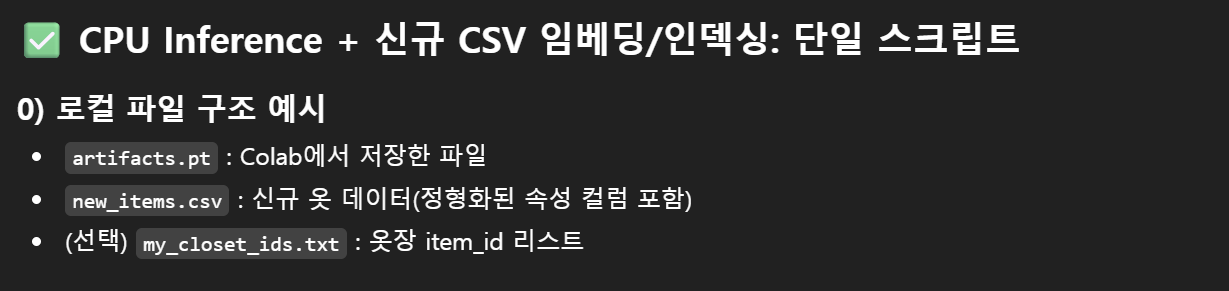

In [ ]:
import re
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

import torchtext
from torchtext.data.utils import get_tokenizer

In [ ]:
def parse_temperature_to_int(temp_text: str) -> int:
    s = str(temp_text).strip()
    negative = False
    if "영하" in s or s.startswith("-"):
        negative = True
    m = re.search(r"(-?\d+(\.\d+)?)", s)
    if not m:
        raise ValueError(f"Cannot parse temperature: {temp_text}")
    val = float(m.group(1))
    if negative and val > 0:
        val = -val
    return int(round(val))


def safe_temp_range(tr, default=(-50, 50)) -> Tuple[int, int]:
    # tr가 (min,max) tuple/list/문자열 등 뭐가 와도 최대한 안전하게 (int,int)로 정규화
    if tr is None:
        return default
    if isinstance(tr, (list, tuple)) and len(tr) == 2:
        try:
            return (int(tr[0]), int(tr[1]))
        except:
            return default
    if isinstance(tr, str):
        # "[0,10]" 같은 문자열 대응
        nums = re.findall(r"-?\d+", tr)
        if len(nums) >= 2:
            try:
                return (int(nums[0]), int(nums[1]))
            except:
                return default
    return default


def normalize_str(x) -> Optional[str]:
    if x is None:
        return None
    if isinstance(x, float) and pd.isna(x):
        return None
    s = str(x).strip()
    if s in ("", "없음", "None", "nan", "NaN"):
        return None
    return s


def get_item_id(meta: dict) -> str:
    # meta dict에서 item_id를 robust하게 꺼냄
    for k in ("item_id", "image_id", "id", "ID"):
        if k in meta and meta[k] is not None:
            return str(meta[k])
    raise KeyError(f"meta에 item_id/image_id/id 키가 없습니다. meta keys={list(meta.keys())}")


# part alias: 한글/영문/축약 혼재 대응
PART_ALIAS = {
    "top": "상의",
    "upper": "상의",
    "상의": "상의",

    "bottom": "하의",
    "pants": "하의",
    "trousers": "하의",
    "하의": "하의",

    "outer": "아우터",
    "outerwear": "아우터",
    "아우터": "아우터",

    "dress": "원피스",
    "onepiece": "원피스",
    "원피스": "원피스",
}

def normalize_part(x) -> Optional[str]:
    s = normalize_str(x)
    if s is None:
        return None
    key = s.strip().lower()
    return PART_ALIAS.get(key, s)  # alias 없으면 원본 유지


@dataclass
class RuntimeConfig:
    max_len: int
    text_emb_dim: int
    text_hidden_dim: int
    cat_emb_dim: int
    item_hidden_dim: int
    embed_dim: int
    temperature: float
    text_use_attn: bool = False
    text_attn_nhead: int = 4
    text_attn_ff: int = 256

In [ ]:
class TextEncoder(nn.Module):
    """
    - 기본: Embedding -> masked mean pooling -> MLP -> normalize
    - 옵션: 1-layer self-attention
    """
    def __init__(self, vocab_size: int, emb_dim: int, hidden_dim: int, out_dim: int, pad_idx: int,
                 use_attn: bool = False, nhead: int = 4, ff_dim: int = 256):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.use_attn = use_attn
        if use_attn:
            layer = nn.TransformerEncoderLayer(
                d_model=emb_dim, nhead=nhead, dim_feedforward=ff_dim, batch_first=True
            )
            self.attn = nn.TransformerEncoder(layer, num_layers=1)
        else:
            self.attn = None

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        x = self.emb(input_ids)  # (B,L,D)

        if self.use_attn:
            key_padding_mask = (attention_mask == 0)  # True=mask
            x = self.attn(x, src_key_padding_mask=key_padding_mask)

        mask = attention_mask.unsqueeze(-1).float()
        x = x * mask
        denom = mask.sum(dim=1).clamp_min(1.0)
        pooled = x.sum(dim=1) / denom

        z = self.mlp(pooled)
        return F.normalize(z, dim=-1)


class ItemEncoder(nn.Module):
    def __init__(self, maps, feature_cols, emb_dim, hidden_dim, out_dim):
        super().__init__()
        self.feature_cols = feature_cols
        self.embs = nn.ModuleDict({col: nn.Embedding(len(maps[col]), emb_dim) for col in feature_cols})
        in_dim = emb_dim * len(feature_cols)
        self.proj = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, feats: Dict[str, torch.Tensor]) -> torch.Tensor:
        vecs = []
        for col in self.feature_cols:
            vecs.append(self.embs[col](feats[col]))
        x = torch.cat(vecs, dim=1)
        z = self.proj(x)
        return F.normalize(z, dim=-1)

In [ ]:
ART_PATH = "artifacts.pt"  # 필요 시 경로 수정

payload = torch.load(ART_PATH, map_location="cpu")

# 버전 체크(토크나이저 동일성에 영향 가능)
saved_versions = payload.get("versions", {})
print("[saved versions]", saved_versions)
print("[local versions]", {"torch": torch.__version__, "torchtext": torchtext.__version__})
if saved_versions.get("torchtext") and saved_versions["torchtext"] != torchtext.__version__:
    print("WARNING: torchtext version mismatch -> tokenizer behavior may differ (성능 변동 가능)")

cfg = RuntimeConfig(**payload["cfg"])
FEATURE_COLS = payload["FEATURE_COLS"]
maps = payload["maps"]

tv = payload["text_vocab"]
itos = tv["itos"]
stoi = tv["stoi"]
pad_idx = int(tv["pad_idx"])
unk_idx = int(tv["unk_idx"])

tokenizer = get_tokenizer("basic_english")  # ✅ 동일 API

# 모델 구성 (주의: cfg.text_use_attn 여부가 저장된 구조와 동일해야 로딩됨)
text_enc = TextEncoder(
    vocab_size=len(itos),
    emb_dim=cfg.text_emb_dim,
    hidden_dim=cfg.text_hidden_dim,
    out_dim=cfg.embed_dim,
    pad_idx=pad_idx,
    use_attn=cfg.text_use_attn,
    nhead=cfg.text_attn_nhead,
    ff_dim=cfg.text_attn_ff,
).eval()

item_enc = ItemEncoder(
    maps=maps,
    feature_cols=FEATURE_COLS,
    emb_dim=cfg.cat_emb_dim,
    hidden_dim=cfg.item_hidden_dim,
    out_dim=cfg.embed_dim,
).eval()

text_enc.load_state_dict(payload["text_enc_state"])
item_enc.load_state_dict(payload["item_enc_state"])

# 인덱스
item_embs = payload["item_embs"].float().contiguous()   # (N,d)
item_metas = payload["item_metas"]                      # list aligned

# 최소 테이블(없어도 동작하게 방어)
item_table_min = payload.get("item_table_min", {})
WEATHER_LABEL_TO_TEMP_RANGE = payload.get("WEATHER_LABEL_TO_TEMP_RANGE", {})

print("Loaded index:", item_embs.shape, "metas:", len(item_metas))

In [ ]:
@torch.no_grad()
def encode_text(query: str) -> torch.Tensor:
    tokens = tokenizer(query)
    ids = [stoi.get(t, unk_idx) for t in tokens][: cfg.max_len]
    attn = [1] * len(ids)
    if len(ids) < cfg.max_len:
        pad_len = cfg.max_len - len(ids)
        ids += [pad_idx] * pad_len
        attn += [0] * pad_len

    input_ids = torch.tensor(ids, dtype=torch.long).unsqueeze(0)
    attention = torch.tensor(attn, dtype=torch.long).unsqueeze(0)
    z = text_enc(input_ids, attention).cpu()  # (1,d)
    return z


@torch.no_grad()
def encode_items_from_df(df: pd.DataFrame, id_col: str = "image_id") -> Tuple[torch.Tensor, List[dict]]:
    if id_col not in df.columns:
        raise ValueError(f"df must include id_col='{id_col}'")

    # feature cols 누락 방어: 없으면 None으로 채워서 <unk>로 들어가게
    for col in FEATURE_COLS:
        if col not in df.columns:
            df[col] = None

    feats = {col: [] for col in FEATURE_COLS}
    metas = []

    for _, row in df.iterrows():
        iid = str(row[id_col])

        # part
        part = normalize_part(row.get("part", None) or row.get("category", None))

        # temp_range: csv에 날씨 라벨이 있으면 맵핑, 없으면 넓게
        wlab = normalize_str(row.get("날씨", None))
        temp_range = (-50, 50)
        if wlab is not None:
            # weather_map 키가 int/str 혼재 가능 -> 둘 다 시도
            if wlab in WEATHER_LABEL_TO_TEMP_RANGE:
                temp_range = tuple(WEATHER_LABEL_TO_TEMP_RANGE[wlab])
            else:
                try:
                    wi = str(int(wlab))
                    if wi in WEATHER_LABEL_TO_TEMP_RANGE:
                        temp_range = tuple(WEATHER_LABEL_TO_TEMP_RANGE[wi])
                except:
                    pass
        temp_range = safe_temp_range(temp_range)

        metas.append({"item_id": iid, "part": part, "temp_range": temp_range})

        for col in FEATURE_COLS:
            m = maps[col]
            v = normalize_str(row.get(col, None))
            key = v if v is not None else "<unk>"
            feats[col].append(m.get(key, 0))

    feats_t = {col: torch.tensor(vals, dtype=torch.long) for col, vals in feats.items()}
    z = item_enc(feats_t).cpu()  # (M,d)
    return z, metas


def merge_new_items_into_index(
    item_embs: torch.Tensor,
    item_metas: List[dict],
    new_embs: torch.Tensor,
    new_metas: List[dict],
    overwrite_existing: bool = True
) -> Tuple[torch.Tensor, List[dict], dict]:

    id_to_idx = {get_item_id(m): i for i, m in enumerate(item_metas)}
    replaced = 0
    appended = 0
    skipped = 0

    # 교체는 텐서 in-place 가능
    for e, m in zip(new_embs, new_metas):
        iid = get_item_id(m)
        if iid in id_to_idx:
            if overwrite_existing:
                idx = id_to_idx[iid]
                item_metas[idx] = m
                item_embs[idx] = e
                replaced += 1
            else:
                skipped += 1
        else:
            item_metas.append(m)
            item_embs = torch.cat([item_embs, e.unsqueeze(0)], dim=0).contiguous()
            id_to_idx[iid] = len(item_metas) - 1
            appended += 1

    info = {"replaced": replaced, "appended": appended, "skipped": skipped, "new_total": len(item_metas)}
    return item_embs, item_metas, info

In [ ]:
# 예시: 사용자 옷장 id 리스트 (여기에 넣으시면 됩니다)
user_closet_ids = [
    "123", "456", "789"
]

# 2번째 예시
# closet_df = pd.read_csv("my_closet.csv")  # 예: image_id 컬럼이 있음
# user_closet_ids = closet_df["image_id"].astype(str).tolist()

In [ ]:
def recommend_topk_by_part_with_temp(
    user_closet_ids: List[str],
    query: str,
    current_temp_text: str,
    k: int = 5,
    parts: Tuple[str, ...] = ("상의", "하의", "아우터", "원피스"),
    temp_margin: int = 2,
    print_scores: bool = True,
):
    current_temp = parse_temperature_to_int(current_temp_text)
    closet = set(map(str, user_closet_ids))

    # 1) 옷장 필터: 인덱스에서 closet에 있는 것만
    idxs = []
    metas = []
    for i, m in enumerate(item_metas):
        iid = get_item_id(m)
        if iid in closet:
            idxs.append(i)
            # meta 정규화(특히 part/temp_range)
            mm = dict(m)
            mm["item_id"] = iid
            mm["part"] = normalize_part(mm.get("part", None) or mm.get("category", None))
            mm["temp_range"] = safe_temp_range(mm.get("temp_range", None))
            metas.append(mm)

    if len(idxs) == 0:
        raise ValueError("옷장 item_id가 현재 인덱스(item_metas)에 하나도 없습니다. (id 키 이름/값 확인 필요)")

    embs = item_embs[idxs]  # (M,d)

    # 2) 기온 필터
    ok_mask = []
    for mm in metas:
        iid = mm["item_id"]
        # item_table_min이 있으면 우선
        if iid in item_table_min:
            tr = safe_temp_range(item_table_min[iid].get("temp_range", None))
            part_tbl = normalize_part(item_table_min[iid].get("part", None))
            if mm.get("part") is None and part_tbl is not None:
                mm["part"] = part_tbl
        else:
            tr = safe_temp_range(mm.get("temp_range", None))

        mm["temp_range"] = tr
        tmin, tmax = tr
        ok = (tmin - temp_margin) <= current_temp <= (tmax + temp_margin)
        ok_mask.append(ok)

    ok_mask = torch.tensor(ok_mask, dtype=torch.bool)

    # 3) 텍스트 임베딩
    zt = encode_text(query)               # (1,d)
    sims = (zt @ embs.T).squeeze(0)       # (M,)

    if print_scores:
        print("=" * 90)
        print(f"query: {query}")
        print(f"temp: {current_temp_text} -> {current_temp}°C (margin={temp_margin})")
        print(f"closet size: {len(metas)} | after temp filter: {int(ok_mask.sum().item())}")
        print("=" * 90)

    results = {}
    for part in parts:
        part_mask = torch.tensor([mm.get("part") == part for mm in metas], dtype=torch.bool)
        mask = ok_mask & part_mask

        if int(mask.sum().item()) == 0:
            results[part] = []
            if print_scores:
                print(f"[{part}] no candidates")
            continue

        sims_f = sims.clone()
        sims_f[~mask] = -1e9
        topv, topi = torch.topk(sims_f, k=min(k, int(mask.sum().item())))

        rows = []
        if print_scores:
            print(f"\n[{part}] top-{len(topi)}")

        for rank, (score, li) in enumerate(zip(topv.tolist(), topi.tolist()), 1):
            iid = metas[li]["item_id"]
            tr = metas[li]["temp_range"]
            rows.append({"item_id": iid, "score": float(score), "temp_range": tr, "part": part})
            if print_scores:
                print(f"  {rank:>2}. {iid}  score={score:.4f}  temp={tr[0]}~{tr[1]}")

        results[part] = rows

    return results

In [ ]:
query = "캐주얼한 주말 카페룩"
current_temp_text = "8도"  # API에서 들어온 기온 텍스트(예: "영하 3도", "-2", "5°C" 등도 가능)

res = recommend_topk_by_part_with_temp(
    user_closet_ids=user_closet_ids,
    query=query,
    current_temp_text=current_temp_text,
    k=5,
    parts=("상의", "하의", "아우터", "원피스"),
    temp_margin=2,
    print_scores=True,
)
res

In [ ]:
# 신규 옷 CSV 들어왔을 때: 임베딩 + 인덱스 갱신
new_df = pd.read_csv("new_items.csv")  # 신규 정형화 아이템 데이터
new_embs, new_metas = encode_items_from_df(new_df, id_col="image_id")
item_embs, item_metas, info = merge_new_items_into_index(item_embs, item_metas, new_embs, new_metas, overwrite_existing=True)
print(info)